<a href="https://colab.research.google.com/github/egagli/amath563/blob/main/labs/7/Lab7_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7: Applications and Extensions of RNNs 


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

## Preprocess Data

#### Included with this lab are TSLA.csv, GOOGL.csv and DJI.csv files. Use Pandas to retrieve the dataset. 
#### Use only Open price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [2]:
dji_df = pd.read_csv('DJI.csv')
google_df = pd.read_csv('GOOGL.csv')
tesla_df = pd.read_csv('TSLA.csv')

## Plot Stocks

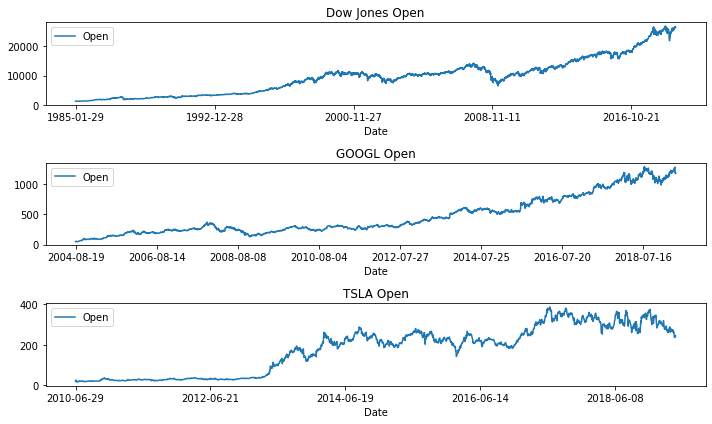

In [3]:
f,ax=plt.subplots(3,1,figsize=(10,6),sharex=False)
dji_df.plot(x='Date',y='Open', ax=ax[0])
ax[0].set_title('Dow Jones Open')
google_df.plot(x='Date',y='Open', ax=ax[1])
ax[1].set_title('GOOGL Open')
tesla_df.plot(x='Date',y='Open', ax=ax[2])
ax[2].set_title('TSLA Open')
plt.tight_layout()

## Choose stock to predict

In [4]:
which = 0
stocks = [dji_df,google_df,tesla_df]
stock_names = ['Dow Jones','Google','Tesla']
stock = stocks[which]
stock_name = stock_names[which]

## Normalize and split data

In [5]:
def normalize_and_split(stock, input_window,train_split): # adapted from https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    stock_open = stock[['Open']]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized = scaler.fit_transform(stock_open.values.reshape(-1,1))

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - input_window): 
        data.append(normalized[index: index + input_window])
    
    data = np.array(data);
    test_set_size = int(np.round((1-train_split)*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    Xtrain = data[:train_set_size,:-1,:]
    Ytrain = data[:train_set_size,-1,:]
    
    Xtest = data[train_set_size:,:-1]
    Ytest = data[train_set_size:,-1,:]

    return [np2tnsr(Xtrain), np2tnsr(Ytrain), np2tnsr(Xtest), np2tnsr(Ytest)]

def np2tnsr(array):
    return torch.from_numpy(array).type(torch.Tensor)

In [6]:
train_split = 0.8
input_window = 10
Xtrain, Ytrain, Xtest, Ytest = normalize_and_split(stock, train_split=train_split, input_window = input_window)

## Define RNN (Here I used GRU)

In [7]:
class GRUModel(nn.Module): # adapted from lab 7 notes pdf
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn,cn) = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

## Set Hyperparameters

In [8]:
input_dim = 1
hidden_dim = 16
num_layers = 2
output_dim = 1
num_epochs = 50

In [9]:
model = GRUModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Train Model

In [10]:
MSEs = np.zeros(num_epochs)

for i in range(num_epochs):
    Ytrain_guess = model(Xtrain)
    loss = criterion(Ytrain_guess, Ytrain)
    #print(f'Epoch: {i+1} MSE: {loss.item():0.6f}')
    MSEs[i] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Text(0.5, 1.0, 'Dow Jones \nTraining Loss vs Epoch \nEpochs: 50 Using Adam with Learning Rate = 0.001')

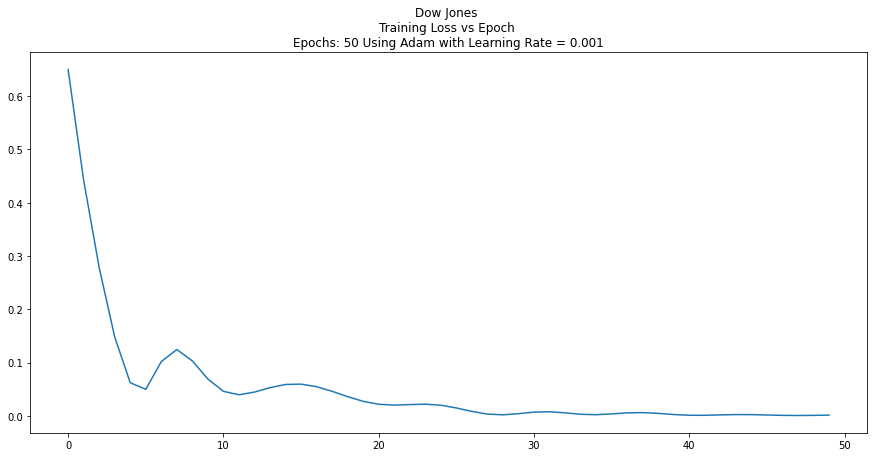

In [11]:
f,ax=plt.subplots(figsize=(15,7))
ax.plot(MSEs)
ax.set_title(f'{stock_name} \nTraining Loss vs Epoch \nEpochs: {num_epochs} Using Adam with Learning Rate = 0.001')

## Test Model

In [12]:
with torch.no_grad():
  Ytest_guess = model(Xtest)
  loss = criterion(Ytest_guess, Ytest)

In [13]:
scale_up_train = MinMaxScaler(feature_range=(stock[:len(Ytrain_guess)]['Open'].min(), stock[:len(Ytrain_guess)]['Open'].max()))
scale_up_test = MinMaxScaler(feature_range=(stock[-len(Ytest_guess):]['Open'].min(), stock[-len(Ytest_guess):]['Open'].max()))
Ytest_guess_scaledup = scale_up_test.fit_transform(Ytest_guess)
Ytrain_scaledup = scale_up_train.fit_transform(Ytrain_guess.detach().numpy())

In [14]:
stock['Date'] = pd.to_datetime(stock['Date'])

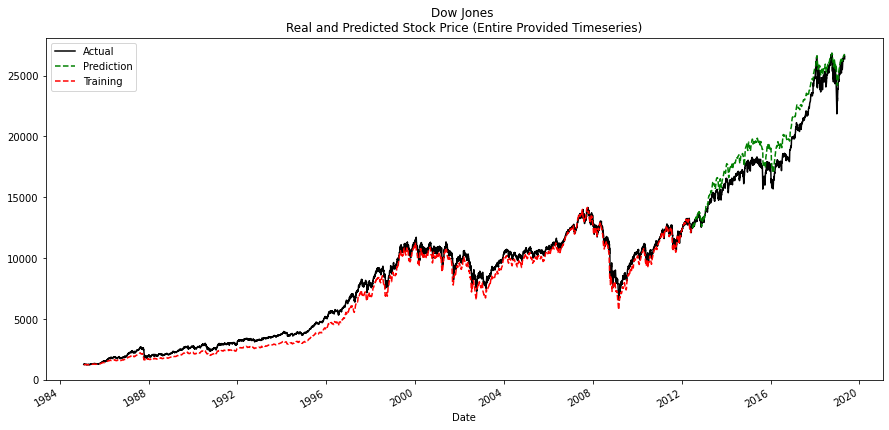

In [15]:
f,ax=plt.subplots(figsize=(15,7))
stock.plot(x='Date',y='Open',label='Actual',ax=ax,color='black')
ax.plot(stock[-len(Ytest_guess_scaledup):]['Date'].values,Ytest_guess_scaledup,'g--',label='Prediction') # need to plot dates#ax.plot(stock[:len(Ytest_guess_scaledup)]['Date'],Ytest_scaledup,label='Actual')
ax.plot(stock[:len(Ytrain_scaledup)]['Date'].values,Ytrain_scaledup,'r--',label='Training')
ax.set_title(f'{stock_name} \nReal and Predicted Stock Price (Entire Provided Timeseries)')
ax.legend()

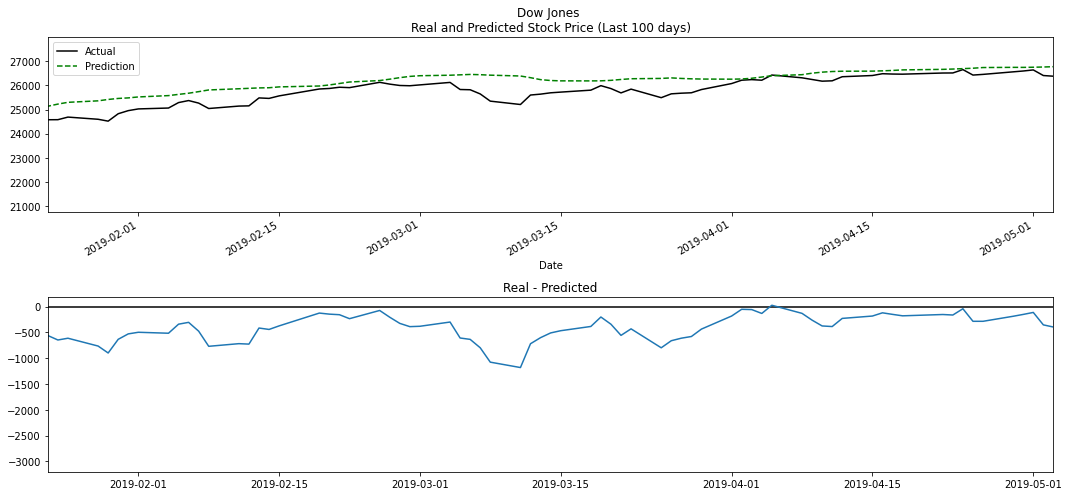

In [16]:
f,ax=plt.subplots(2,1,figsize=(15,7))
stock.plot(x='Date',y='Open',label='Actual',ax=ax[0],color='black')
ax[0].plot(stock[-len(Ytest_guess_scaledup):]['Date'].values,Ytest_guess_scaledup,'g--',label='Prediction') # need to plot dates#ax.plot(stock[:len(Ytest_guess_scaledup)]['Date'],Ytest_scaledup,label='Actual')
ax[0].set_title(f'{stock_name} \nReal and Predicted Stock Price (Last 100 days)')
ax[0].legend()
ax[0].set_xlim([pd.to_datetime('01-23-2019'),pd.to_datetime('05-03-2019')])
ax[0].set_ylim([stock[-100:]['Open'].values.min()*0.95,stock[-100:]['Open'].values.max()*1.05])

differences = stock[-100:]['Open'].values - Ytest_guess_scaledup[-100:].squeeze()
ax[1].plot(stock[-100:]['Date'].values,differences)
ax[1].hlines(y=0,xmin=pd.to_datetime('01-23-2019'),xmax=pd.to_datetime('05-03-2019'))
ax[1].set_xlim([pd.to_datetime('01-23-2019'),pd.to_datetime('05-03-2019')])
ax[1].set_title('Real - Predicted')

plt.tight_layout()